In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Dataset/'dogs-vs-cats'
!ls 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/Dataset/dogs-vs-cats
sampleSubmission.csv  test1  test1.zip	train  train.zip


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import random


# Helper Function


In [250]:
def read_data(input,test=False):
  input=input.reset_index(drop=True)
  new_size=256;images=[];category=[]
  %cd /gdrive/My Drive/Dataset/'dogs-vs-cats'/test1

  if not test:
    %cd /gdrive/My Drive/Dataset/'dogs-vs-cats'/train
    for i in range(input.shape[0]):
      temp=cv2.imread(input.loc[i,'filenames'])
      images.append(cv2.resize(temp,(new_size,new_size)))
      category.append(input.loc[i,'category'])
  for i in range(input.shape[0]):
    temp=cv2.imread(input.loc[i,'filenames'])
    images.append(cv2.resize(temp,(new_size,new_size)))
  return images,category

In [ ]:
import numpy as np
class Conv2D:
  def __init__(self, num_filters,kernel_size):
      self.num_filters = num_filters
      self.kernel_size=kernel_size
  
  def get_filters(self,input_shape):
      return np.random.randn(self.num_filters, self.kernel_size, self.kernel_size,input_shape[2]) / self.kernel_size*self.kernel_size

  def get_subset(self, image):
    image_list=[];x,y,_=image.shape
    for i in range(x-self.kernel_size+1):
      for j in range(y-self.kernel_size+1):
        image_list.append(image[i:(i + self.kernel_size), j:(j + self.kernel_size),:])
    return image_list

  def forward(self, input):
    if len(input.shape)<3:
      input=input.reshape(input.shape[0],input.shape[1],1)   
    
    x,y,z=input.shape
    self.last_input = input
    output = np.zeros((x-self.kernel_size+1,y-self.kernel_size+1, self.num_filters))
    
    image_list=self.get_subset(input)
    self.filters=self.get_filters(input.shape)
    div=y-self.kernel_size+1

    for f in range(self.num_filters):
      i=0;j=0
      for idx,img in enumerate(image_list):
        if idx%div==0:
          i+=1;j=0;
        output[i-1, j, f] = np.sum(img * self.filters[f])
        j+=1
    # For relu activation, uncomment the next line
    #output[output<0]=0
    return output
    
  def backprop(self, d_L_d_out, learn_rate):
    z=0
    d_L_d_filters = np.zeros(self.filters.shape)
    output=np.zeros(self.last_input.shape)
    
    for f in range(d_L_d_out.shape[2]):
      for i in range(d_L_d_out.shape[0]):
        for j in range(d_L_d_out.shape[1]):
          for ii in range(self.kernel_size):
            for jj in range(self.kernel_size):
              for ff in range(z):
                output[i+ii,j+jj,ff]+=self.filters[f,ii,jj,ff]*d_L_d_out[i,j,f]
                d_L_d_filters[f,ii,jj,ff]+=self.last_input[i+ii,j+jj,ff]*d_L_d_out[i,j,f]
   
    self.filters -= learn_rate * d_L_d_filters
    # For relu activation, uncomment the next line
#    output[output<0]=0
    return output

In [ ]:
class MaxPool:
   def __init__(self,poolsize):
     self.poolsize=poolsize
   def get_subset(self, image):
    x,y,num_channels=image.shape;   image_list=[]
    for i in range(x//self.poolsize):
      for j in range(y//self.poolsize):
        image_list.append(image[(i * self.poolsize):(i * self.poolsize + self.poolsize), (j * self.poolsize):(j * self.poolsize + self.poolsize)])
    return image_list

   def forward(self, input):
     x, y,num_channels = input.shape
     self.last_input=input
     output = np.zeros((x//self.poolsize,y//self.poolsize, num_channels))
     image_list=self.get_subset(input)
     i=0;j=0;div=y//self.poolsize
     for idx,img in enumerate(image_list):
       if idx%div==0:
         i+=1;j=0;
       output[i-1, j] = np.amax(img, axis=(0, 1))
       j+=1
     output= np.array(output)
     return output
     
   def backprop(self,dL_dout):
     d_L_d_input = np.zeros((dL_dout.shape[0]*self.poolsize,dL_dout.shape[1]*self.poolsize,dL_dout.shape[2]*self.poolsize))
     x, y,num_channels = self.last_input.shape
     image_list=self.get_subset(self.last_input)
     i=0;j=0;div=y//self.poolsize
     for idx,img in enumerate(image_list):
       if idx%div==0:
         i+=1;j=0;
       
       h, w, f = img.shape
       amax = np.amax(img, axis=(0, 1))
       for i2 in range(h):
         for j2 in range(w):
           for f2 in range(f):
             if img[i2, j2, f2] == amax[f2]:
               d_L_d_input[(i-1) * self.poolsize + i2, j * self.poolsize + j2, f2] = dL_dout[i-1, j, f2]
       j+=1

     return d_L_d_input

In [ ]:
class Dense:
  # A standard fully-connected layer with softmax activation.

  def __init__(self, nodes,activation):
    self.activation=activation
    self.nodes=nodes
    
  def get_weights(self,input):
    if len(input.shape)==1 or type(input)==int:
      input_size=len(input)
    else:
      input_size=input.shape[0]*input.shape[1]*input.shape[2]
    weights = np.random.randn(input_size, self.nodes) / input_size
    biases = np.zeros(self.nodes)
    return weights,biases

  def forward(self, input):
    input=np.array(input)
    self.last_input_shape = input.shape
    self.weights,self.biases=self.get_weights(input)
    input = input.flatten()
    self.last_input = input
    input_len, nodes = self.weights.shape
    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals
    output=0
    if self.activation == 'Softmax':
      exp = np.exp(totals)
      output=exp / np.sum(exp, axis=0)
    elif self.activation == 'Relu':
      output=[max(0.0,val) for val in totals]
    elif self.activation == 'Sigmoid':
      output=sigmoid(totals)
    return output

  def backprop(self, d_L_d_out, learn_rate):
        if self.activation=='Sigmoid':
          d_out_d_t=sigmoid(self.last_totals,derivative=True)
        elif self.activation=='Relu':
          d_out_d_t=Relu(self.last_totals,derivative=True)
        elif self.activation=='Softmax':
          d_out_d_t=Softmax(self.last_totals,d_L_d_out,derivative=True)
          # Gradients of totals against weights/biases/input
        d_t_d_w = self.last_input
        d_t_d_b = 1
        d_t_d_inputs = self.weights

      # Gradients of loss against totals
        d_L_d_t = d_L_d_out * d_out_d_t

      # Gradients of loss against weights/biases/input
        d_L_d_w =np.matmul(d_t_d_w[np.newaxis].T , d_L_d_t[np.newaxis])
        d_L_d_b = d_L_d_t * d_t_d_b
        d_L_d_inputs = np.matmul(d_t_d_inputs , d_L_d_t)

      # Update weights / biases
        self.weights -= learn_rate * d_L_d_w
        self.biases -= learn_rate * d_L_d_b
        return d_L_d_inputs.reshape(self.last_input_shape)


In [ ]:
class Dropout:
  def __init__(self,prob):
    self.prob=prob  
  def forward(self,X):
    keep_prob = 1 - self.prob
    mask = np.random.uniform(0, 1.0, X.shape) < keep_prob
    if keep_prob > 0.0:
        scale = (1/keep_prob)
    else:
        scale = 0.0
    return mask * X * scale
  def backprop(self,X):
    return self.forward(X)

In [ ]:
def CrossEntropy(yHat, y):
  epsilon=1e-15
  if y == 1:
      return -np.log(epsilon+yHat)
  else:
      return -np.log(1 - yHat+epsilon)
   
def Relu(x,derivative=False):
  if derivative:
    x[x<=0]=0
    x[x>0]=1
    return x
  x[x<0]=0

  return x

def sigmoid(x, derivative=False):
   if derivative:
      return (np.exp(-x))/((np.exp(-x)+1)**2)
   return 1/(1 + np.exp(-x))

def Softmax(x,d_L_d_out, derivative=False):
  if derivative:
    for i, gradient in enumerate(d_L_d_out):
      if gradient==0:
          continue
      t_exp = np.exp(x)
      S = np.sum(t_exp)
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)
    return d_out_d_t  
  exps = np.exp(x - x.max())
  return exps / np.sum(exps, axis=0)

Relu(np.array([0,1,0.5,-1,-5,5]),True)


array([0., 1., 1., 0., 0., 1.])

In [ ]:

class Sequential():
  def __init__(self,input_shape,lr=0.005):
    self.input_shape=input_shape
    self.lr=lr
    self.layers=[]
    self.epsilon=1e-15

  def addlayers(self,layers):
    self.layers.append(layers)

  def printlayers(self):
    for layers in (self.layers):
      print(layers)

  def forward(self,image):
    out=image/255   
    for layers in self.layers:
      out = layers.forward(out)
    return out

  def backward(self,gradient):
    for layers in reversed(self.layers):
      if "Dropout" in str(type(layers)) or "MaxPool" in str(type(layers)):
        gradient=layers.backprop(gradient)
      else:
        gradient=layers.backprop(gradient,self.lr)
 
  def train(self,image,label):
    out=self.forward(image)
    if getattr(self.layers[-1],'activation')=='Sigmoid':
      acc = 1 if np.round(out) == label else 0
      loss = CrossEntropy(out,label)
      gradient=label-out
    elif getattr(self.layers[-1],'activation')=='Softmax':
      acc = 1 if np.argmax(out) == label else 0
      gradient=np.zeros(getattr(self.layers[-1],'nodes'))
      gradient[label]=-1/(out+self.epsilon)
      loss=-np.log(out[label])
    self.backward(gradient)
    #print(out,label)
    return acc,loss

  def fit(self,image,labels,epochs):
    print("-"*50,"Training started","-"*50)
    c = list(zip(image, labels))
    random.shuffle(c)
    a,b=zip(*c)
    #for full training, use the next line
    #train_data=zip(a,b)
    train_data=zip(a[:20],b[:20])
    net_acc=0;net_loss=0
    for epoch in range(epochs):
      print('--- Epoch %d ---' % (epoch + 1))
      loss = 0;num_correct = 0
      for i, (im, label) in enumerate(train_data):
        if i > 0 and i % 50 == 0:
          print('[Step %d] 50 samples trained: Average Loss %.3f || Accuracy: %d%%' %(i + 1, loss / 50, num_correct*2))
          loss = 0
          num_correct = 0
        #print(label)  
        acc,l=self.train(im,label)
        loss += l;net_loss+=l
        num_correct += acc; net_acc+=acc
      print("completed epoch %d || Average Training loss : %0.3f || Training Accuracy : %0.2f%%"%(epoch+1,net_loss/i,net_acc/i*100))
  
  def predict(self,image):
      output=[]
      for im in image:
        if getattr(self.layers[-1],'activation')=='Sigmoid':
          output.append(np.round(self.forward(im)))
        elif getattr(self.layers[-1],'activation')=='Softmax':
          output.append(np.argmax(self.forward(im)))
      return output
    
  


In [ ]:
def confusion_matrix(yHat, y):
  tp=sum([1 for i,val in enumerate(yHat) if val==y[i] and val==1])
  tn=sum([1 for i,val in enumerate(yHat) if val==y[i] and val==0])
  fn=sum([1 for i,val in enumerate(yHat) if val!=y[i] and val==0])
  fp=sum([1 for i,val in enumerate(yHat) if val!=y[i] and val==1])
  return tp,tn,fp,fn
 
def accuracy(yHat,y):
  out=[1 for i,val in enumerate(yHat) if val==y[i]] 
  return sum(out)/len(y)
def recall(yHat,y):
  tp,tn,fp,fn=confusion_matrix(yHat, y)
  return tp/(tp+fn)
def precision(yHat,y):
  tp,tn,fp,fn=confusion_matrix(yHat, y)
  return tp/(tp+fp)
def F1_Score(yHat,y):
  return 2*precision(yHat,y)*recall(yHat,y)/(precision(yHat,y)+recall(yHat,y))

# Read Data

In [246]:

%cd /gdrive/My Drive/Dataset/'dogs-vs-cats'/train

filenames = os.listdir("./")
categories = [];list_filenames=[]
for filename in filenames:
      list_filenames.append(filename)
      category = filename.split('.')[0]
      if category == 'dog':
        categories.append(1)
      else:
        categories.append(0)
    
    
train_data=pd.DataFrame({'filenames':list_filenames,'category':categories})
#######################################################
%cd /gdrive/My Drive/Dataset/'dogs-vs-cats'/test1

filenames = os.listdir("./")
categories = [];list_filenames=[]
for filename in filenames:
      list_filenames.append(filename)
      category = filename.split('.')[0]
      if category == 'dog':
        categories.append(1)
      else:
        categories.append(0)
    
    
test_data=pd.DataFrame({'filenames':list_filenames,'category':categories})


/gdrive/My Drive/Dataset/dogs-vs-cats/train
/gdrive/My Drive/Dataset/dogs-vs-cats/test1


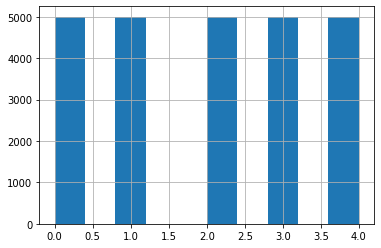

In [247]:
#create validation folds
train_data['folds']=0
cats=train_data[train_data['category']==0].reset_index(drop=True)
dogs=train_data[train_data['category']==1].reset_index(drop=True)
total_length=train_data.shape[0]
start_idx=0;inc=total_length/10;num_folds=5
new_df=pd.DataFrame()
for i in range(num_folds):
  cats.loc[np.arange(start_idx,start_idx+inc),'folds']=i
  dogs.loc[np.arange(start_idx,start_idx+inc),'folds']=i
  start_idx+=inc
train_data=cats.append(dogs).reset_index(drop=True)
train_data.folds.hist()

# Define model+training

In [ ]:
def create_model(input_shape):
  model=Sequential(input_shape);num_filters=8;poolsize=2
  model.addlayers(Conv2D(num_filters=24,kernel_size=5))
  model.addlayers(MaxPool(poolsize=2))  
  model.addlayers(Conv2D(num_filters=32,kernel_size=5))
  model.addlayers(MaxPool(poolsize=2))
  model.addlayers(Dropout(prob=0.5))
  model.addlayers(Dense(nodes=1000,activation='Relu'))
  model.addlayers(Dense(nodes=1,activation='Sigmoid'))
  return model

In [ ]:
num_folds=5
test_out=np.zeros(test_data.shape[0])
test_images,_=read_data(test_data,True);
for i in range(num_folds):
  print('-'*75,"Fold %d"%(i+1),'-'*75)
  train_images,train_labels=read_data(train_data[train_data.folds!=i])
  val_images,val_labels=read_data(train_data[train_data.folds==i])
  model=create_model(train_images[0].shape)
  model.fit(image=train_images,labels=train_labels,epochs=1)
  preds=model.predict(val_images)
  preds=[int(val) for val in preds]
  print("validation: accuracy : %0.2f%% || precision : %0.2f || recall : %0.2f || F1-Score : %0.4f"%(accuracy(preds,val_labels)*100,precision(preds,val_labels),recall(preds,val_labels),F1_Score(preds,val_labels)))
  #predicting testdata
  preds=model.predict(test_images)
  preds=[int(val) for val in preds]
  test_out+=preds/num_folds
  


In [ ]:
test_data['category']=test_out